In [23]:
import tensorflow as tf
# Explicitly disable eager execution
tf.compat.v1.disable_eager_execution()

In [2]:
!pip3 install -U ucimlrepo 

  Attempting uninstall: ucimlrepo
    Found existing installation: ucimlrepo 0.0.6
    Uninstalling ucimlrepo-0.0.6:
      Successfully uninstalled ucimlrepo-0.0.6


In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
room_occupancy_estimation = fetch_ucirepo(id=864) 
  
# data (as pandas dataframes) 
X = room_occupancy_estimation.data.features 
y = room_occupancy_estimation.data.targets 
  
# # metadata 
# print(room_occupancy_estimation.metadata) 
  
# # variable information 
# print(room_occupancy_estimation.variables) 


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from ucimlrepo import fetch_ucirepo
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW, Yogi  # You need TensorFlow Addons for AdamW and Yogi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import time
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
# Load the dataset
room_occupancy_estimation = fetch_ucirepo(id=864)

# Get features and target
X = room_occupancy_estimation.data.features
y = room_occupancy_estimation.data.targets

# Convert to DataFrame
df = pd.DataFrame(X, columns=room_occupancy_estimation.feature_names)


In [6]:
df.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0


In [7]:
# Check the column names of the DataFrame
print(df.columns)

Index(['Date', 'Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR'],
      dtype='object')


In [8]:
# df.drop(columns=[ "Date"], inplace=True)
df.drop(columns=["Date", "Time"], inplace=True)

Data Preprocessing 

In [9]:
def normalization(df):
  for i in df.columns:
    upper_bound = df[i].max()
    lower_bound = df[i].min()
    df[i] = (df[i]-lower_bound)/(upper_bound-lower_bound)
  return df

X_norm = normalization(df)

In [10]:
df["TempSum"] = df.iloc[:,:3].sum(axis = 1)
df["TempMin"] =df.iloc[:,:3].min(axis = 1)
df["TempMax"] = df.iloc[:,:3].max(axis = 1)
df["TempAvg"] = df.iloc[:,:3].mean(axis = 1)
df["LightSum"] = df.iloc[:,4:8].sum(axis = 1)
df["LightMin"] = df.iloc[:,4:8].min(axis = 1)
df["LightMax"] = df.iloc[:,4:8].max(axis = 1)
df["LightAvg"] = df.iloc[:,4:8].mean(axis = 1)
df["SoundSum"] = df.iloc[:,8:12].sum(axis = 1)
df["SoundMin"] = df.iloc[:,8:12].min(axis = 1)
df["SoundMax"] = df.iloc[:,8:12].max(axis = 1)
df["SoundAvg"] = df.iloc[:,8:12].mean(axis = 1)

In [11]:
def normalization(df):
  for i in df.columns:
    upper_bound = df[i].max()
    lower_bound = df[i].min()
    df[i] = (df[i]-lower_bound)/(upper_bound-lower_bound)
  return df

X_norm = normalization(df)

In [12]:
y = to_categorical(y)

In [13]:
y.shape

(10129, 4)

In [14]:
num_classes = y.shape[1]


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [16]:
# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [17]:
X_train.shape

(7292, 28)

In [18]:
y_train.shape

(7292, 4)

In [19]:
# Define window length for TimeseriesGenerator
window_length = 24 # Assuming a window length of 24 samples

# Create TimeseriesGenerator for training data
train_generator = TimeseriesGenerator(X_train, y_train, length=window_length, batch_size=32)

# Create TimeseriesGenerator for validation data
val_generator = TimeseriesGenerator(X_val, y_val, length=window_length, batch_size=32)

# Create TimeseriesGenerator for test data
test_generator = TimeseriesGenerator(X_test, y_test, length=window_length, batch_size=32)

In [20]:
train_generator.data.shape

(7292, 28)

In [21]:
# Define the NeuralNetworkModel class
class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_lstm(self, input_shape, num_classes, optimizer):
        self.model = Sequential()
        self.model.add(LSTM(units=50, input_shape=input_shape))
        self.model.add(Dense(num_classes, activation='softmax'))  # Assuming 3 classes for classification
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    def train(self, train_generator, val_generator, epochs, batch_size):
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        history = self.model.fit(train_generator, epochs=epochs, batch_size=batch_size, validation_data=val_generator, callbacks=[early_stopping, reduce_lr])
        return history

    
    def evaluate(self, test_generator):
        # Generate predictions
        y_pred_prob = self.model.predict(test_generator)

        # Extract true labels from test generator
        y_true = []
        for i in range(len(test_generator)):
            _, labels = test_generator[i]
            y_true.extend(labels)
        y_true = np.argmax(y_true, axis=1)

        # Convert predictions to class labels
        y_pred = np.argmax(y_pred_prob, axis=1)

        # Compute evaluation metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        return accuracy, precision, recall, f1


In [31]:
# List of optimizers to test for NN
optimizers = {
    'SGD': SGD(),
    'SGD_momentum': SGD(momentum=0.9),
    'Nesterov': SGD(momentum=0.9, nesterov=True),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adam': Adam(),
    'AMSGrad': Adam(amsgrad=True),
    'AdamW': AdamW(weight_decay=1e-4),
    'Yogi': Yogi(),
    'Nadam': tf.keras.optimizers.Nadam(),
    'Adamax': tf.keras.optimizers.Adamax()
}

results = {}

# neural_network_model = NeuralNetworkModel()

for name, optimizer in optimizers.items():
    print(f"Training model with {name} optimizer...")
    neural_network_model = NeuralNetworkModel()
    neural_network_model.build_lstm((window_length, X_train.shape[1]), num_classes= num_classes ,optimizer=optimizer)
    start_time = time.time()
    # history = neural_network_model.train(train_generator, y_train, val_generator, y_val, epochs=1, batch_size=32)
    history = neural_network_model.train(train_generator, val_generator, epochs=50, batch_size= 32)
    end_time = time.time()
    test_accuracy, precision, recall, f1 = neural_network_model.evaluate(test_generator)
    training_time = end_time - start_time
    convergence_speed = len(history.history['loss'])
    results[name] = {
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'convergence_speed': convergence_speed,
        'training_time': training_time,
        'history': history
    }

Training model with SGD optimizer...


ValueError: The `batch_size` argument must not be specified for the given input type. Received input: <keras.preprocessing.sequence.TimeseriesGenerator object at 0x000002EF637464A0>, batch_size: 32

In [68]:
# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Precision - {result['precision']:.4f}, "
          f"Recall - {result['recall']:.4f}, "
          f"F1-score - {result['f1_score']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")


Results:
SGD: Test Accuracy - 0.9161, Precision - 0.8463, Recall - 0.9161, F1-score - 0.8792, Convergence Speed - 22 epochs, Training Time - 90.04 seconds
SGD_momentum: Test Accuracy - 0.8806, Precision - 0.8591, Recall - 0.8806, F1-score - 0.8593, Convergence Speed - 22 epochs, Training Time - 89.94 seconds
Nesterov: Test Accuracy - 0.8786, Precision - 0.8914, Recall - 0.8786, F1-score - 0.8687, Convergence Speed - 22 epochs, Training Time - 88.77 seconds
RMSprop: Test Accuracy - 0.8716, Precision - 0.8917, Recall - 0.8716, F1-score - 0.8758, Convergence Speed - 22 epochs, Training Time - 89.99 seconds
Adagrad: Test Accuracy - 0.8721, Precision - 0.8251, Recall - 0.8721, F1-score - 0.8473, Convergence Speed - 41 epochs, Training Time - 168.40 seconds
Adadelta: Test Accuracy - 0.8746, Precision - 0.7650, Recall - 0.8746, F1-score - 0.8161, Convergence Speed - 50 epochs, Training Time - 202.89 seconds
Adam: Test Accuracy - 0.9176, Precision - 0.8698, Recall - 0.9176, F1-score - 0.8923,

In [69]:
# Data extraction for the summary
data_info = {
    'Data Name': ["Room Occupancy Estimation"] * len(optimizers),
    'Data Size': [X_train.shape[0]] * len(optimizers),
    'Number of Features': [X_train.shape[1]] * len(optimizers),
    'Target Feature Type': [y_train.dtype] * len(optimizers),
    'Neural Network Architecture': ["LSTM"] * len(optimizers),
    'Optimization Method': list(optimizers.keys())
}

# Extract results for each optimization method
results_info = {
    'Optimization Method': [],
    'Test Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'Convergence Speed': [],
    'Training Time': [],
    'Training Loss': [],
    'Validation Loss': []
}

# Add the evaluation results for each optimizer
for optimizer, result in results.items():
    results_info['Optimization Method'].append(optimizer)
    results_info['Test Accuracy'].append(result['test_accuracy'])
    results_info['Precision'].append(result['precision'])
    results_info['Recall'].append(result['recall'])
    results_info['F1-score'].append(result['f1_score'])
    results_info['Convergence Speed'].append(result['convergence_speed'])
    results_info['Training Time'].append(result['training_time'])
    results_info['Training Loss'].append(result['history'].history['loss'][0])
    results_info['Validation Loss'].append(result['history'].history['val_loss'][0])

# Create DataFrames and merge them for final results
data_df = pd.DataFrame(data_info)
results_df = pd.DataFrame(results_info)
final_df = pd.merge(data_df, results_df, on='Optimization Method')

# Show the final merged data
final_df.head(12)

,Data Name,Data Size,Number of Features,Target Feature Type,Neural Network Architecture,Optimization Method,Test Accuracy,Precision,Recall,F1-score,Convergence Speed,Training Time,Training Loss,Validation Loss
0,Room Occupancy Estimation,7292,28,float32,LSTM,SGD,0.916084,0.846304,0.916084,0.879220,22,90.041713,0.759313,0.184539
1,Room Occupancy Estimation,7292,28,float32,LSTM,SGD_momentum,0.880619,0.859123,0.880619,0.859256,22,89.944379,0.440969,0.164617
2,Room Occupancy Estimation,7292,28,float32,LSTM,Nesterov,0.878621,0.891386,0.878621,0.868709,22,88.765928,0.435264,0.170247
3,Room Occupancy Estimation,7292,28,float32,LSTM,RMSprop,0.871628,0.891688,0.871628,0.875826,22,89.987480,0.447541,0.191171
4,Room Occupancy Estimation,7292,28,float32,LSTM,Adagrad,0.872128,0.825090,0.872128,0.847251,41,168.396581,1.213330,1.011286
5,Room Occupancy Estimation,7292,28,float32,LSTM,Adadelta,0.874625,0.764970,0.874625,0.816131,50,202.893102,1.421676,1.435720
6,Room Occupancy Estimation,7292,28,float32,LSTM,Adam,0.917582,0.869754,0.917582,0.892261,25,102.464213,0.465135,0.155277
7,Room Occupancy Estimation,7292,28,float32,LSTM,AMSGrad,0.885614,0.848546,0.885614,0.866401,26,103.461356,0.451767,0.171558
8,Room Occupancy Estimation,7292,28,float32,LSTM,AdamW,0.886613,0.891469,0.886613,0.887176,22,91.621100,0.480431,0.152578
9,Room Occupancy Estimation,7292,28,float32,LSTM,Yogi,0.885614,0.926485,0.885614,0.891243,24,104.356878,0.461549,0.197129


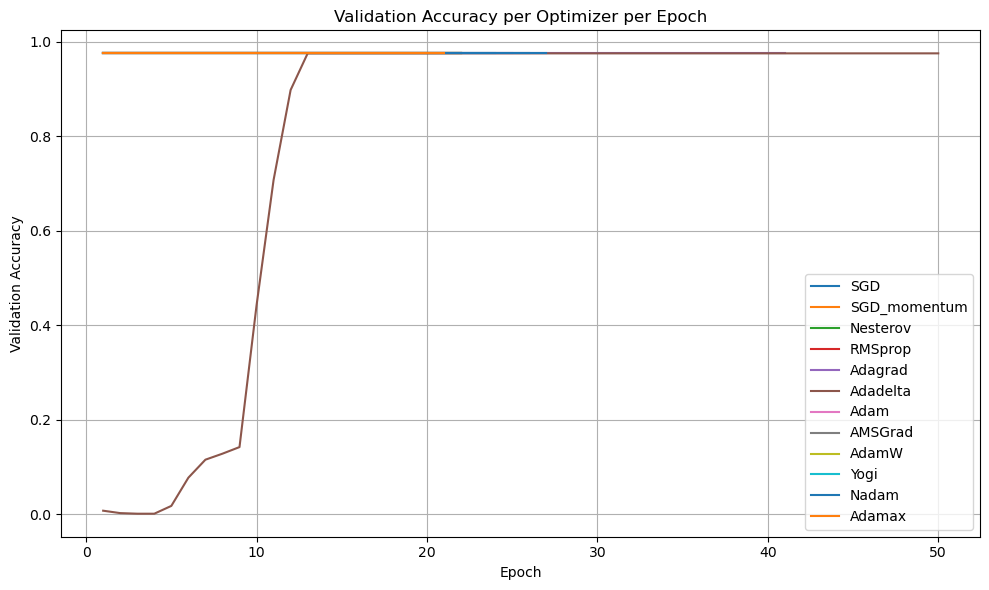

In [70]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Test Accuracy per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the validation accuracy history for this optimizer
    if 'val_accuracy' in result['history'].history:
        val_acc_history = result['history'].history['val_accuracy']
    else:
        # Sometimes the key might be 'val_acc', depending on TensorFlow version
        val_acc_history = result['history'].history.get('val_acc', [])

    # Plot the validation accuracy history
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label=optimizer_name)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Optimizer per Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


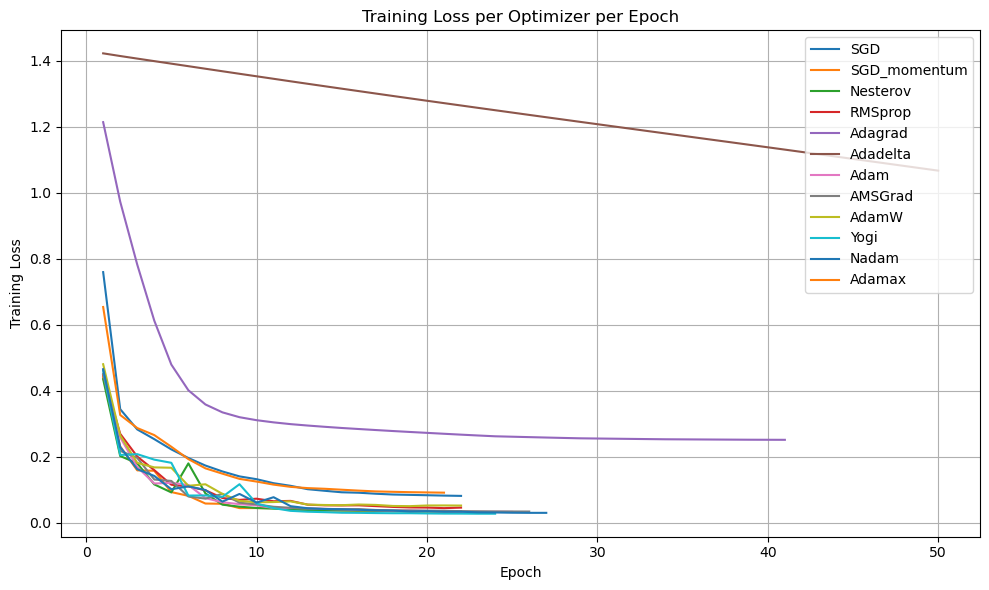

In [71]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Training Loss per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the training loss history for this optimizer
    if 'loss' in result['history'].history:
        loss_history = result['history'].history['loss']
    else:
        # In case the loss key isn't found (unexpected behavior), use a default empty list
        loss_history = []

    # Plot the training loss history
    plt.plot(range(1, len(loss_history) + 1), loss_history, label=optimizer_name)

# Set plot labels and titles
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Optimizer per Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [72]:
final_df.to_csv('Room Occupancy Estimation.csv', index=False)

In [41]:
# # Define and train the LSTM model
# model = Sequential([
#     LSTM(50, activation='relu', input_shape=(window_length, X_train.shape[1])),
#     Dense(4, activation='softmax')
# ])

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(train_generator, epochs=3, validation_data=val_generator)

# # Evaluate the model on test data
# loss, accuracy = model.evaluate(test_generator)
# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)

In [23]:
# # Generate predictions
# y_pred_prob = model.predict(test_generator)
# y_pred = np.argmax(y_pred_prob, axis=1)

# # Extract true labels from test generator
# y_true = []
# for i in range(len(test_generator)):
#     _, labels = test_generator[i]
#     y_true.extend(labels)
# y_true = np.argmax(y_true, axis=1)

# # Compute additional evaluation metrics
# precision = precision_score(y_true, y_pred, average='weighted')
# recall = recall_score(y_true, y_pred, average='weighted')
# f1 = f1_score(y_true, y_pred, average='weighted')

# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1)

63/63 [==============================] - 1s 16ms/step
Precision: 0.8702920358967482
Recall: 0.8766233766233766
F1 Score: 0.8727047839848051


In [24]:
# # Define the NeuralNetworkModel class
# class NeuralNetworkModel:
#     def __init__(self):
#         self.model = None

#     def build_ann(self, input_shape, optimizer):
#         self.model = Sequential([
#             LSTM(50, activation='relu', input_shape=(window_length, X_train.shape[1])),
#             Dense(4, activation='softmax')
#         ])
#         self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#     def train(self, X_train, X_val, epochs, batch_size):
#         early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
#         reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
#         return self.model.fit( X_train, X_val, epochs=1, batch_size=32, callbacks=[early_stopping, reduce_lr]
#         # return self.model.fit( X_train, X_val, epochs=1, batch_size=32
#     )

    
#     def evaluate(self, X_test):
#         y_pred_prob = self.model.predict(X_test)
#         y_pred = np.argmax(y_pred_prob, axis=1)
#         accuracy = accuracy_score(y_test, y_pred)
#         precision = precision_score(y_test, y_pred, average='weighted')
#         recall = recall_score(y_test, y_pred, average='weighted')
#         f1 = f1_score(y_test, y_pred, average='weighted')
#         return accuracy, precision, recall, f1

In [59]:
# Select features with high correlation to the target
k_best_features = SelectKBest(score_func=f_regression, k=5)
k_best_features.fit(df, y)
selected_features = df.columns[k_best_features.get_support(indices=True)].tolist()


C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [60]:
# Select the relevant columns from the DataFrame
X_selected = df[selected_features]

In [105]:
X_selected

,S1_Temp,S1_Light,S2_Light,S3_Light,S7_PIR
0,24.94,121,34,53,0
1,24.94,121,33,53,0
2,25.00,121,34,53,0
3,25.00,121,34,53,0
4,25.00,121,34,54,0
...,...,...,...,...,...
10124,25.06,6,7,33,0
10125,25.06,6,7,34,0
10126,25.13,6,7,34,0
10127,25.13,6,7,34,0


In [61]:
df["Room_Occupancy_Count"] = y

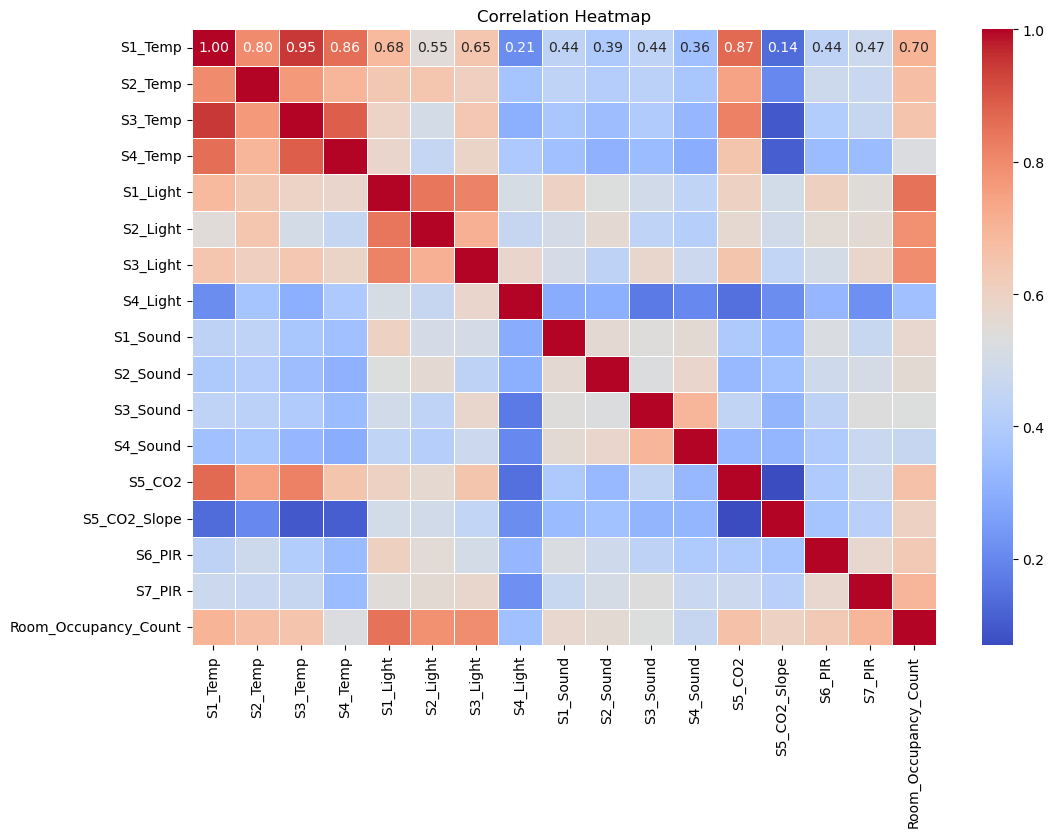

In [66]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [67]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_selected)

In [68]:
# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)


In [76]:
X_train.shape

(7292, 5)

In [104]:
X_train

array([[0.        , 0.73333333, 0.13178295, 0.18928571, 0.        ],
       [0.        , 0.73333333, 0.12790698, 0.18928571, 0.        ],
       [0.04166667, 0.73333333, 0.13178295, 0.18928571, 0.        ],
       ...,
       [0.25694444, 0.        , 0.        , 0.        , 0.        ],
       [0.25694444, 0.        , 0.        , 0.        , 0.        ],
       [0.25694444, 0.        , 0.        , 0.        , 0.        ]])

In [129]:
# Define window length for TimeseriesGenerator
window_length = 24 # Assuming a window length of 24 samples

# Create TimeseriesGenerator for training data
train_generator = TimeseriesGenerator(X_train, y_train, length=window_length, batch_size=1)

# Create TimeseriesGenerator for validation data
val_generator = TimeseriesGenerator(X_val, y_val, length=window_length, batch_size=1)

# Create TimeseriesGenerator for test data
test_generator = TimeseriesGenerator(X_test, y_test, length=window_length, batch_size=1)

In [130]:
train_generator.data.shape[1]

5

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(window_length, train_generator.data.shape[1]), return_sequences=True),
    LSTM(32, return_sequences=False),
    Dense(1)
])

# # Compile the model
# model.compile(optimizer='adam', loss='mse')

# # Print the model summary
# model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(train_generator, epochs=50, validation_data=val_generator)

# # Evaluate the model on test data
# loss, accuracy = model.evaluate(test_generator)
# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)

In [135]:
# Train the model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

KeyError: 24